In [1]:
import io
import matplotlib

from matplotlib import pyplot as plt
import numpy as np
import sys

import os.path
import sys
#file_dir = os.path.dirname(__file__)
#sys.path.append(file_dir)
#sys.path.append(os.path.join(os.path.dirname(__file__), '..'))
#sys.path.append('../')
#print(sys.path)
import time
import math
import random
import matplotlib
import numpy as np
##import ioLAMMPS
##import netgen
##from relax import Optimizer
from numpy import linalg as LA
from scipy.optimize import fsolve
from matplotlib import pyplot as plt

import shutil
src="./Run1/param.py"
dst="param.py"
shutil.copyfile(src, dst)
import param as p
import networkx as nx



def meanr2_fun(n_chains, chains, links, Lx, Ly, Lz):
    meanr2=0
    dist = np.zeros((n_chains,4))
    dist[:,0:3] = chains[:,1:]
    dist[:,3] = -1
        
    for i in range (0, n_chains):
        if(chains[i,2] !=-1):
      
          link_1 = chains[i,2]-1
          link_2 = chains[i,3]-1
          lk = links[link_1,:] - links[link_2,:]
          
          lk[0] = lk[0] - int(round(lk[0]/Lx))*Lx
          lk[1] = lk[1] - int(round(lk[1]/Ly))*Ly
          lk[2] = lk[2] - int(round(lk[2]/Lz))*Lz
                
          dist[i,3] = LA.norm(lk)
          meanr2=meanr2+(dist[i,3])**2
##          print(dist[i,3])
##          stop
##          print(((dist[i,3])**2)/(p.N_low*p.b_low**2))
          

    return meanr2

def readLAMMPS_after_netgen(filename, vflag,G, folder):

   f1=open(filename,"r")

   line1 = f1.readline()
   line2 = f1.readline()

   line3 = f1.readline()
   line3 = line3.strip()
   n_links = int(line3.split(" ")[0])
 
   line4 = f1.readline()
   line4 = line4.strip()
   atom_types = int(line4.split(" ")[0])

   line5 = f1.readline()
   line5 = line5.strip()
   n_chains = int(line5.split(" ")[0])

   line6 = f1.readline()\
           
   line6 = line6.strip()
   bond_types = int(line6.split(" ")[0])

   links_unsort  = np.zeros((n_links,4))
   links   = np.zeros((n_links,3), dtype = float)
   chains  = np.full((n_chains,4), -1, dtype = int)
   mass    = np.zeros(atom_types, dtype = float)

   line7 = f1.readline()
   line8 = f1.readline()
   line8 = line8.strip()
   xlo = float(line8.split(" ")[0])
   xhi = float(line8.split(" ")[1])

   line9 = f1.readline()
   line9 = line9.strip()
   ylo = float(line9.split(" ")[0])
   yhi = float(line9.split(" ")[1])

   line10 = f1.readline()
   line10 = line10.strip()
   zlo = float(line10.split(" ")[0])
   zhi = float(line10.split(" ")[1])


   for i in range (0, 3):
       f1.readline()
   
   for i in range(0, atom_types):
       line = f1.readline()
       line = line.strip()
       mass[i] = float(line.split(" ")[1])

   f1.close()


   links_unsort = np.genfromtxt(filename, usecols=(0,3,4,5), skip_header=18, max_rows=n_links)

   for i in range(0, n_links):
       index = int(links_unsort[i,0])
       links[index-1,:] = links_unsort[i,1:4]


##   chains[:,0] = N
#cnt,ctype,1,conn1,conn2
   if(vflag==0):
      chains[:,0:4] = np.genfromtxt(filename,usecols=(0,1,2,3), skip_header=17+n_links+3, max_rows=n_chains)
   elif(vflag==1):
      chains[:,0:4] = np.genfromtxt(filename,usecols=(0,1,2,3), skip_header=17+2*n_links+2*3, max_rows=n_chains)
   else:
      print("Invalid Velocity Flag")
##   print(chains)

   for c in chains:
      [lnk_1,lnk_2]=c[2:4]
      G.add_edge(lnk_1,lnk_2)
##   directory = './'+str(int(100*frac_weak))+'/'
   filename = 'primary_loops'
##   file_path = os.path.join(directory, filename)
##   if not os.path.isdir(directory):
##      os.mkdir(directory)  
   loop_atoms = np.genfromtxt(folder+"0/"+filename , usecols=(1), skip_header=0)
   loop_atoms.tolist() 

   return xlo, xhi, ylo, yhi, zlo, zhi, n_links, n_chains, links, chains, atom_types, bond_types, mass, loop_atoms,G


L 51.746804735448904
C_mM 0.11984188583311728


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


area 194405.13402256469 33350.48831792863
gamma 0.3300521355760322 0.004574793980949276
modulus_theory 293.9941715606204 4.075000951417482
modulus_tensile 271.3583746156918 11.13613669284972


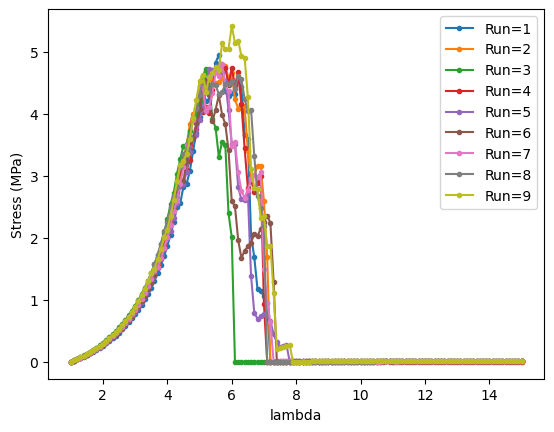

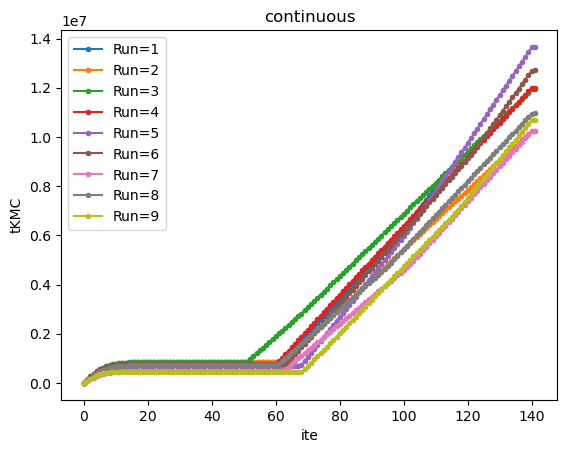

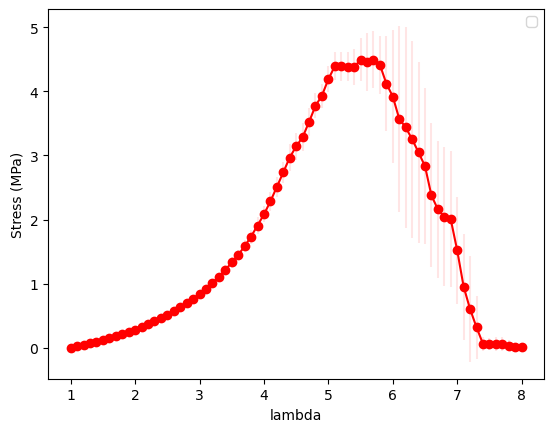

In [2]:
run_list=[1,2,3,4,5,6,7,8,9]##[1,3,4,5,6,7]##[1,2,3,4,5,6,7,8,9]##,10
area_list=[]
stress_list=[]
gamma_list=[]

modulus_theory_list=[]
modulus_tensile_list=[]

len_stress=71
stress_all=np.zeros((len(run_list),len_stress))
lambda_list=np.zeros(len_stress)
run_cnt=-1
for run in run_list:
    run_cnt=run_cnt+1
    folder="./Run"+str(run)+"/"
    temps = []
    with io.open(folder+"0/"+"stress", mode="r") as f:
        next(f)
        for line in f:
            temps.append(line.split())

    Lx=[float(i[0]) for i in temps]
    Ly=[float(i[1]) for i in temps]
    Lz=[float(i[2]) for i in temps]

    lam=[i[3] for i in temps]
    lam=[float(i) for i in lam]


    FE=[i[4] for i in temps]
    FE=[float(i) for i in FE] #free energy stored in chain
    deltaFE=[i[5] for i in temps]
    deltaFE=[float(i) for i in deltaFE]

    st0=[i[6] for i in temps]
    st0=[float(i) for i in st0]
    st1=[i[7] for i in temps]
    st1=[float(i) for i in st1]
    st2=[i[8] for i in temps]
    st2=[float(i) for i in st2]
    st3=[i[9] for i in temps]
    st3=[float(i) for i in st3]
    st4=[i[10] for i in temps]
    st4=[float(i) for i in st4]
    st5=[i[11] for i in temps]
    st5=[float(i) for i in st5]
    factor=4.11
    st0=np.array(st0)*factor
    st1=np.array(st1)*factor
    st2=np.array(st2)*factor
    st3=np.array(st3)*factor
    st4=np.array(st4)*factor
    st5=np.array(st5)*factor
    ##st6=np.array(st6)
    
    tKMC_arr=[float(i[12]) for i in temps]
    ite_arr=[i for i in range(len(tKMC_arr))]

    ##stop


    ##size=sys.getsizeof(st1)
    ##factor=np.zeros((1,size))
    ##mylist = list(xrange(10))
    ##factor=np.zeros((1,size))
    ##a=st1+st2;
    ##a=[0.5*i for i in a]
    stress=st0-0.5*(st1+st2)
    stress_list.append(np.array(stress))
    '''
    plt.plot(lam,st0,label='pxx')
    plt.plot(lam,st1,label='pyy')
    plt.plot(lam,st2,label='pzz')
    plt.plot(lam,st3,label='pxy')
    plt.plot(lam,st4,label='pyz')
    plt.plot(lam,st5,label='pzx')

    plt.xlabel('lambda')
    plt.ylabel('pressure/stress components')
    plt.legend()

    plt.figure()
    plt.plot(lam,deltaFE,label='deltaFE')
    plt.xlabel('lambda')
    plt.ylabel('delta Free Energy')
    plt.legend()
    '''
    #print(lam)
    #print(deltaFE)

    #plt.figure()
    plt.figure(1)
    xaxis=[(x)/Lx[0] for x in Lx]
    plt.plot(xaxis,-stress,'.-',label='Run='+str(run))
    plt.xlabel('lambda')
    plt.ylabel('Stress (MPa)')
    plt.legend()

    file1=open(folder+"data.txt","w")
    for i in range(len(xaxis)):
        file1.write("{:7} {:7} \n".format(xaxis[i],-stress[i]))
    file1.close()

    plt.savefig(folder+"stress_lambda_x_cont.png")
    
    stress_all[run_cnt,:]=-stress[0:len_stress]
    lam_list=xaxis[0:len_stress]

    area=np.trapz(-stress, tKMC_arr,0.001)
    file2=open(folder+"area.txt","w")
    file2.write(str(area))
    file2.close()
    area_list.append(area)
    
    plt.figure(2)
    plt.title('continuous')
    
    plt.plot(ite_arr,tKMC_arr,'.-',label='Run='+str(run))
    plt.ylabel('tKMC')
    plt.xlabel('ite')
    plt.legend()
    
   
    
    cnt=10
    z = np.polyfit(xaxis[0:cnt], -stress[0:cnt], 1)
    ##plt.figure(2)
    ##plt.plot(np.array(xaxis[0:cnt]),z[1]+z[0]*np.array(xaxis[0:cnt]),'r-' )
    plt.savefig(folder+"stress_lambda_x_with_fit.png")
    modulus_tensile_list.append(z[0]*1000)

    #print('z=',z)
    #print('Modulus (kPa) (from tensile test) = ', z[0]*1000)
    #plt.show()
    parameters=np.zeros([2,6]) # N, b, K, fit_param, E_b,U0

    frac_weak_array_py=[0.0]#,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    ##frac_weak_array_py=frac_weak_array_py[my_task_id-1:len(frac_weak_array_py):num_tasks]      

    for frac_weak in frac_weak_array_py:


       netgen_flag = 0
       swell = 0
       if(netgen_flag==0):

          vflag = 0
       ##   N = 12   
    ##      print('--------------------------')   
    ##      print('----Reading Network-------')   
    ##      print('--------------------------')

          filename = "restart_network_0.txt"
    ##      file_path = os.path.join(directory, filename)
    ##      if not os.path.isdir(directory):
    ##         os.mkdir(directory)
          G=nx.Graph()
          [xlo, xhi, ylo, yhi, zlo, zhi, n_atoms, n_bonds, atoms, bonds, 
                  atom_types, bond_types, mass, loop_atoms,G] = readLAMMPS_after_netgen(folder+"0/"+filename, vflag, G,folder)


          mean_r2=meanr2_fun(n_bonds, bonds, atoms, (xhi-xlo), (yhi-ylo), (zhi-zlo))
          gamma=mean_r2/(p.n_chains*p.N_low*p.b_low**2)
          gamma_list.append(gamma)
          #print('gamma',gamma)
          G=p.conc*(10000/6.022)*gamma*8.314*298  #0.05*6.022*1.38*gamma*300
         # print('G',G)
          E=3*G
          #print('E (kPa) (from gamma analysis)',0.001*E)

          modulus_theory_list.append(0.001*E)

    
mean_gamma=np.mean(gamma_list)
std_gamma=np.std(gamma_list)
mean_area=np.mean(area_list)
std_area=np.std(area_list)

mean_modulus_tensile=np.mean(modulus_tensile_list)
std_modulus_tensile=np.std(modulus_tensile_list)

mean_modulus_theory=np.mean(modulus_theory_list)
std_modulus_theory=np.std(modulus_theory_list)

std_gamma=np.std(gamma_list)
#mean_stress=np.mean(np.array(stress_list), axis=0)
#std_stress=np.std(np.array(stress_list), axis=0)
print('area',mean_area,std_area)
##print('std_area',std_area)
print('gamma',mean_gamma,std_gamma)
print('modulus_theory', mean_modulus_theory, std_modulus_theory)
print('modulus_tensile', mean_modulus_tensile, std_modulus_tensile)
#print('std_gamma',std_gamma)
stress_mean=np.mean(stress_all,axis=0)
stress_std=np.std(stress_all,axis=0)
plt.figure()
markers, caps, bars =plt.errorbar(lam_list,stress_mean, yerr=stress_std,fmt="r-o")##,ecolor="black")
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]
plt.xlabel('lambda')
plt.ylabel('Stress (MPa)')
plt.legend()
np.savetxt('gamma.txt',np.array([mean_gamma,std_gamma]))

np.savetxt('stress_strain_data_avg.txt',np.transpose(np.array([lam_list, stress_mean, stress_std])), header='lam_list, stress_mean, stress_std')

##np.savetxt('stress_strain_data_avg.txt',np.transpose(np.array([lam_list, stress_mean, stress_std])), header='lam_list, stress_mean, stress_std')

In [3]:
np.savetxt('stress_strain_data_avg.txt',np.transpose(np.array([lam_list, stress_mean, stress_std])), header='lam_list, stress_mean, stress_std')

In [4]:
p.U0_low

20

In [5]:
len(stress)

142

In [6]:
run

9

In [7]:
st0

array([-1.644000e-03, -2.424900e-02, -4.685400e-02, -7.151400e-02,
       -9.781800e-02, -1.257660e-01, -1.549470e-01, -1.853610e-01,
       -2.198850e-01, -2.560530e-01, -2.942760e-01, -3.357870e-01,
       -3.805860e-01, -4.282620e-01, -4.796370e-01, -5.347110e-01,
       -5.943060e-01, -6.576000e-01, -7.274700e-01, -8.030940e-01,
       -8.852940e-01, -9.744810e-01, -1.072710e+00, -1.180803e+00,
       -1.298760e+00, -1.433157e+00, -1.504260e+00, -1.655508e+00,
       -1.825662e+00, -2.018010e+00, -2.134323e+00, -2.357085e+00,
       -2.614371e+00, -2.915634e+00, -3.179907e+00, -3.239502e+00,
       -3.359514e+00, -3.601593e+00, -3.932448e+00, -4.227957e+00,
       -4.525932e+00, -4.636491e+00, -4.355367e+00, -4.596213e+00,
       -4.665261e+00, -4.757736e+00, -4.716225e+00, -5.140377e+00,
       -5.043381e+00, -5.044203e+00, -5.420679e+00, -5.150241e+00,
       -5.184354e+00, -4.934877e+00, -4.906518e+00, -4.278510e+00,
       -3.116613e+00, -2.808774e+00, -2.784114e+00, -2.320917e

In [8]:
lam_list

[1.0,
 1.1000003864973293,
 1.2000007729946587,
 1.2999992270053413,
 1.3999996135026707,
 1.5,
 1.6000003864973293,
 1.7000007729946587,
 1.7999992270053413,
 1.8999996135026707,
 2.0,
 2.1000003864973293,
 2.2000007729946587,
 2.2999992270053413,
 2.3999996135026707,
 2.5,
 2.6000003864973293,
 2.7000007729946582,
 2.7999992270053413,
 2.8999996135026707,
 3.0,
 3.1000003864973293,
 3.2000007729946587,
 3.2999992270053413,
 3.3999996135026707,
 3.5,
 3.6000003864973293,
 3.7000007729946587,
 3.7999992270053413,
 3.8999996135026707,
 4.0,
 4.100000386497329,
 4.200000772994659,
 4.299999227005341,
 4.399999613502671,
 4.5,
 4.60000038649733,
 4.700000772994659,
 4.799999227005341,
 4.899999613502671,
 5.0,
 5.10000038649733,
 5.200000772994659,
 5.299999227005341,
 5.399999613502671,
 5.5,
 5.599998454010683,
 5.699998840508012,
 5.799999227005341,
 5.899999613502671,
 6.0,
 6.099998454010683,
 6.199998840508012,
 6.299999227005341,
 6.399999613502671,
 6.5,
 6.599998454010683,
 6.699